## Testowanie endpointów FastAPI dla Price Prediction & Optimization Service

Ten notebook umożliwia **lokalne testowanie wszystkich endpointów API**.  
Upewnij się, że serwer FastAPI jest uruchomiony pod adresem **localhost:8000**.

```
cd Solution/app
uvicorn app:app --reload --host 0.0.0.0 --port 8000
```

In [62]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

BASE_URL = "http://localhost:8000"
HEADERS = {"Content-Type": "application/json"}

### Funkcja pomocnicza do testowania endpointów API

Poniższa funkcja służy do **automatycznego testowania endpointów FastAPI** w ramach notebooka lub skryptu testowego.

#### Opis działania

- Funkcja `test_endpoint` wysyła żądania HTTP do wskazanego endpointu API
- Obsługuje metody:
  - `GET`
  - `POST`
- Umożliwia:
  - przekazanie danych w formacie JSON (dla `POST`)
  - sprawdzenie oczekiwanego kodu odpowiedzi (`expected_status`)

#### Logika funkcji

1. Buduje pełny adres URL na podstawie `BASE_URL` i ścieżki endpointu
2. Wysyła żądanie HTTP z nagłówkami (`HEADERS`)
3. Sprawdza kod odpowiedzi:
   - jeśli zgodny z oczekiwanym → zwraca dane JSON
   - w przeciwnym wypadku → wypisuje błąd i zwraca szczegóły odpowiedzi
4. Obsługuje wyjątki (np. brak połączenia z serwerem)

#### Zastosowanie

Funkcja umożliwia:
- szybkie testy regresyjne API
- sprawdzanie poprawności odpowiedzi endpointów
- wygodne debugowanie błędów bezpośrednio w notebooku


In [63]:
def test_endpoint(method, endpoint, data=None, expected_status=200):
    """Test a microservice endpoint."""
    url = f"{BASE_URL}{endpoint}"
    
    try:
        if method == "GET":
            response = requests.get(url, headers=HEADERS)
        elif method == "POST":
            response = requests.post(url, headers=HEADERS, json=data)
        else:
            return {"error": f"Unknown method: {method}"}
        
        if response.status_code == expected_status:
            return response.json()
        else:
            print(f"Error {response.status_code}: {response.text}")
            return {"error": response.text, "status_code": response.status_code}
            
    except Exception as e:
        print(f"Request failed: {e}")
        return {"error": str(e)}

### Sprawdzenie dostępności serwera i załadowanych modeli

Ten blok kodu służy do **weryfikacji, czy serwer FastAPI działa poprawnie** oraz czy wymagane modele zostały poprawnie załadowane po stronie backendu.

#### Co robi ten kod

1. Wysyła zapytanie `GET /` do głównego endpointu API za pomocą funkcji `test_endpoint`
2. Jeśli serwer odpowiada poprawnie:
   - potwierdza dostępność serwera
   - wyświetla:
     - nazwę serwisu
     - wersję API
   - sprawdza status załadowanych modeli (np. regresja, klasyfikacja)
3. Jeśli serwer nie odpowiada lub wystąpi błąd:
   - wypisuje informację o niedostępności serwera
   - wyświetla komunikat błędu

#### Dlaczego to jest ważne

- Pozwala szybko upewnić się, że:
  - serwer FastAPI jest uruchomiony
  - modele ML są dostępne przed testowaniem endpointów
- Stanowi pierwszy krok w **testowaniu end-to-end** całego systemu



In [64]:
print("1.Checking server availability and loaded models\n")
root_info = test_endpoint("GET", "/")
if "error" not in root_info:
    print("Server is available")
    print(f"API version: {root_info.get('version')}")
    print(f"Service name: {root_info.get('service')}")

    print("\nLoaded models:")
    for model, loaded in root_info.get('models_loaded', {}).items():
        status = "loaded" if loaded else "not loaded"
        print(f"  {status} {model}")
else:
    print("Server is not available")
    print(f"Error: {root_info.get('error')}")

1.Checking server availability and loaded models

Server is available
API version: 2.0.0
Service name: Price Prediction & Optimization

Loaded models:
  loaded regression
  loaded classification


### Szybkie sprawdzenie działania API za pomocą `curl`

Ta komenda wykorzystuje narzędzie **`curl`** do wysłania prostego zapytania HTTP typu **GET** do głównego endpointu serwera FastAPI

In [65]:
! curl -X GET "http://localhost:8000/"

{"service":"Price Prediction & Optimization","version":"2.0.0","endpoints":{"/docs":"Interactive API documentation","/predict":"Basic price prediction","/analyze-price":"Price category analysis","/optimize-price":"Price optimization","/full-analysis":"Complete analysis"},"models_loaded":{"regression":true,"classification":true}}

### Pobieranie przykładowych danych wejściowych do testów API

Ten fragment kodu oraz komenda `curl` służą do **sprawdzenia i pobrania przykładowych struktur danych**, które można wykorzystać do testowania endpointów API.


#### Cel
- Zweryfikować, czy endpoint **`/example-request`** działa poprawnie
- Uzyskać **gotowe przykłady danych wejściowych** dla:
  - `/predict`
  - `/analyze-price`



In [66]:
print("2. Getting example request\n")

example_data = test_endpoint("GET", "/example-request")
if "error" not in example_data:
    print("Examples retrieved successfully")
    
    predict_example = example_data["example_for_predict_endpoint"]
    analyze_example = example_data["example_for_analyze_endpoint"]

    print(f"\nExample for /predict:")
    print(f"Number of fields: {len(predict_example)}")
    print(f"First 5 fields: {list(predict_example.keys())[:5]}")

    print(f"\nExample for /analyze-price:")
    print(f"Current price: {analyze_example['current_price']}")
    print(f"Number of features: {len(analyze_example['listing_features'])}")
else:
    print(f"Error: {example_data.get('error')}")

2. Getting example request

Examples retrieved successfully

Example for /predict:
Number of fields: 25
First 5 fields: ['room_type', 'property_type', 'accommodates', 'bedrooms', 'beds']

Example for /analyze-price:
Current price: 476.86
Number of features: 25


In [67]:
! curl -X GET "http://localhost:8000/example-request"

{"example_for_predict_endpoint":{"room_type":"Entire home/apt","property_type":"Entire rental unit","accommodates":4.0,"bedrooms":2.0,"beds":2.0,"bathrooms":1.0,"city":"Athens","neighbourhood_cleansed":"ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ","latitude":37.97506,"longitude":23.73068,"minimum_nights":3.0,"maximum_nights":365.0,"host_is_superhost":1.0,"amenities_count":45.0,"number_of_reviews":33.0,"reviews_per_month":0.22,"avg_rating":4.5,"review_count":33.0,"review_scores_rating":4.84,"review_scores_accuracy":4.91,"review_scores_cleanliness":4.91,"review_scores_checkin":4.88,"review_scores_communication":4.88,"review_scores_location":5.0,"review_scores_value":4.76},"example_for_analyze_endpoint":{"listing_features":{"room_type":"Entire home/apt","property_type":"Entire rental unit","accommodates":4.0,"bedrooms":2.0,"beds":2.0,"bathrooms":1.0,"city":"Athens","neighbourhood_cleansed":"ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ","latitude":37.97506,"longitude":23.73068,"minimum_nights":3.0,"maximum_nights":365.0,"host_is_su

### Testowanie endpointu `/predict`

Ten fragment kodu oraz komenda `curl` służy do **przetestowania endpointu `/predict`**, który odpowiada za **predykcję bazowej (optymalnej) ceny** oferty na podstawie jej cech.

#### Przebieg testu

1. **Przygotowanie danych wejściowych**
   - Wykorzystywany jest wcześniej pobrany przykład `predict_example`
   - Dane te mają dokładnie taką strukturę, jakiej oczekuje endpoint `/predict`

2. **Wysłanie zapytania**
   - Wykonywane jest zapytanie typu `POST` na endpoint `/predict`
   - Dane przekazywane są w formacie JSON

3. **Obsługa odpowiedzi**
   - Jeśli żądanie zakończy się sukcesem:
     - Wyświetlana jest przewidywana cena (`base_price_usd`)
     - Wyświetlany jest komunikat opisowy zwrócony przez API
   - Jeśli wystąpi błąd:
     - Wypisywana jest treść błędu zwróconego przez serwer


Ten test potwierdza, że **podstawowa funkcjonalność predykcji ceny działa poprawnie** i endpoint `/predict` jest gotowy do dalszego wykorzystania.


In [68]:
print("3. Testing /predict endpoint")

predict_payload = predict_example

response = test_endpoint("POST", "/predict", predict_payload)
if "error" not in response:
    print("Prediction successful")
    print(f"Predicted price: ${response.get('base_price_usd'):.2f}")
    print(f"Message: {response.get('message')}")
else:
    print(f"Error: {response.get('error')}")

3. Testing /predict endpoint
Prediction successful
Predicted price: $291.32
Message: Predicted optimal price: $291.32


In [69]:
%%bash
curl -X POST "http://localhost:8000/predict" \
  -H "Content-Type: application/json" \
  -d '{
    "room_type": "Entire home/apt",
    "property_type": "Entire rental unit",
    "accommodates": 4.0,
    "bedrooms": 2.0,
    "beds": 2.0,
    "bathrooms": 1.0,
    "city": "Athens",
    "neighbourhood_cleansed": "ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ",
    "latitude": 37.97506,
    "longitude": 23.73068,
    "minimum_nights": 3.0,
    "maximum_nights": 365.0,
    "host_is_superhost": 1.0,
    "amenities_count": 45.0,
    "number_of_reviews": 33.0,
    "reviews_per_month": 0.22,
    "avg_rating": 4.5,
    "review_count": 33.0,
    "review_scores_rating": 4.84,
    "review_scores_accuracy": 4.91,
    "review_scores_cleanliness": 4.91,
    "review_scores_checkin": 4.88,
    "review_scores_communication": 4.88,
    "review_scores_location": 5.0,
    "review_scores_value": 4.76
    }'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100   882  100    82  100   800   4680  45664 --:--:-- --:--:-- --:--:-- 51882


{"base_price_usd":291.31725196881905,"message":"Predicted optimal price: $291.32"}

### Testowanie endpointu `/analyze-price`

Ten fragment notebooka służy do **przetestowania endpointu `/analyze-price`**, który analizuje aktualną cenę oferty i klasyfikuje ją jako `low`, `normal` lub `high`.

#### Przebieg testu

1. **Przygotowanie danych wejściowych**
   - Wykorzystywany jest przykład `analyze_example`, pobrany wcześniej z endpointu `/example-request`
   - Zawiera on:
     - `listing_features` – cechy oferty
     - `current_price` – aktualną cenę

2. **Wysłanie zapytania POST**
   - Zapytanie trafia do endpointu `/analyze-price`
   - Dane przekazywane są w formacie JSON

3. **Analiza odpowiedzi**
   - W przypadku sukcesu wyświetlane są:
     - aktualna cena
     - przewidywana kategoria ceny (`low`, `normal`, `high`)
     - informacja, czy cena jest konkurencyjna
     - poziom pewności predykcji
   - Dodatkowo wypisywane są:
     - prawdopodobieństwa dla każdej kategorii
     - lista rekomendacji cenowych

4. **Wizualizacja**
   - Tworzony jest wykres słupkowy pokazujący rozkład prawdopodobieństw klas
   - Ułatwia to interpretację niepewności modelu i jego decyzji


4. Testing /analyze-price endpoint
Price analysis successful
Current price: $476.86
Category: normal
Competitive: Yes
Confidence: 94.97%

Category probabilities:
  high: 4.55%
  low: 0.49%
  normal: 94.97%

Recommendations:
  1. Price appears competitive in the market
  2. Monitor performance and adjust if needed
  3. Suggested decrease: $185.54


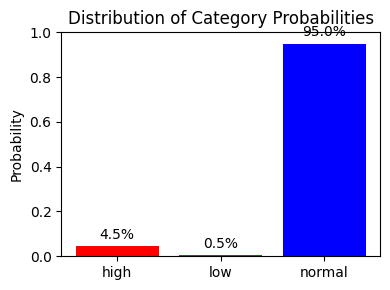

In [70]:
print("4. Testing /analyze-price endpoint")
analyze_payload = analyze_example

response = test_endpoint("POST", "/analyze-price", analyze_payload)
if "error" not in response:
    print("Price analysis successful")
    print(f"Current price: ${response.get('current_price'):.2f}")
    print(f"Category: {response.get('predicted_category')}")
    print(f"Competitive: {'Yes' if response.get('is_competitive') else 'No'}")
    print(f"Confidence: {response.get('confidence'):.2%}")

    print("\nCategory probabilities:")
    probs = response.get('probabilities', {})
    for category, prob in probs.items():
        print(f"  {category}: {prob:.2%}")
    
    print("\nRecommendations:")
    for i, rec in enumerate(response.get('recommendations', []), 1):
        print(f"  {i}. {rec}")
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    categories = list(probs.keys())
    probabilities = list(probs.values())
    colors = ['red', 'green', 'blue']
    
    bars = ax.bar(categories, probabilities, color=colors)
    ax.set_ylabel('Probability')
    ax.set_title('Distribution of Category Probabilities')
    ax.set_ylim(0, 1)

    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob:.1%}', ha='center', va='bottom')
    
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Error: {response.get('error')}")

In [71]:
%%bash
curl -X POST "http://localhost:8000/optimize-price" \
  -H "Content-Type: application/json" \
  -d '{
    "listing_features": {
      "room_type": "Entire home/apt",
      "property_type": "Entire rental unit",
      "accommodates": 4.0,
      "bedrooms": 2.0,
      "beds": 2.0,
      "bathrooms": 1.0,
      "city": "Athens",
      "neighbourhood_cleansed": "ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ",
      "latitude": 37.97506,
      "longitude": 23.73068,
      "minimum_nights": 3.0,
      "maximum_nights": 365.0,
      "host_is_superhost": 1.0,
      "amenities_count": 45.0,
      "number_of_reviews": 33.0,
      "reviews_per_month": 0.22,
      "avg_rating": 4.5,
      "review_count": 33.0,
      "review_scores_rating": 4.84,
      "review_scores_accuracy": 4.91,
      "review_scores_cleanliness": 4.91,
      "review_scores_checkin": 4.88,
      "review_scores_communication": 4.88,
      "review_scores_location": 5.0,
      "review_scores_value": 4.76
    },
    "current_price": 476.86,
    "strategy": "balanced"
  }'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1214  100   277  100   937   6735  22783 --:--:-- --:--:-- --:--:-- 29609


{"current_price":476.86,"recommended_price":291.32,"price_change_pct":-38.91,"current_category":"normal","recommended_category":"normal","expected_revenue_change_pct":103.64,"action":"decrease","explanation":"Decrease price to $291.32 to be more competitive","confidence":0.93}

### 5. Testowanie endpointu `/optimize-price`

Ten fragment notebooka służy do **testowania rekomendacji cenowej** dla pojedynczego ogłoszenia przy użyciu wybranej strategii optymalizacji ceny (`strategy`).

**Wyświetlanie wyników**
   - Rekomendowana cena i procentowa zmiana
   - Sugerowana akcja
   - Oczekiwana zmiana przychodu

In [72]:
print("5. Testing /optimize-price endpoint")

optimize_payload = {
    "listing_features": analyze_example["listing_features"],
    "current_price": analyze_example["current_price"],
    "strategy": "balanced"
}
strategy = optimize_payload["strategy"]
results = {}
print(f"\n Testing strategy: {strategy}")
optimize_payload["strategy"] = strategy
    
response = test_endpoint("POST", "/optimize-price", optimize_payload)
    
if "error" not in response:
    results[strategy] = response
    print(f"  Recommended price: ${response.get('recommended_price'):.2f}")
    print(f"  Price change: {response.get('price_change_pct'):.1f}%")
    print(f"  Action: {response.get('action')}")
    print(f"  Expected revenue change: {response.get('expected_revenue_change_pct', 0):.1f}%")
else:
    print(f"  Error: {response.get('error')}")

5. Testing /optimize-price endpoint

 Testing strategy: balanced
  Recommended price: $291.32
  Price change: -38.9%
  Action: decrease
  Expected revenue change: 103.6%


In [73]:
%%bash
curl -X POST "http://localhost:8000/optimize-price" \
  -H "Content-Type: application/json" \
  -d '{
    "listing_features": {
      "room_type": "Entire home/apt",
      "property_type": "Entire rental unit",
      "accommodates": 4.0,
      "bedrooms": 2.0,
      "beds": 2.0,
      "bathrooms": 1.0,
      "city": "Athens",
      "neighbourhood_cleansed": "ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ",
      "latitude": 37.97506,
      "longitude": 23.73068,
      "minimum_nights": 3.0,
      "maximum_nights": 365.0,
      "host_is_superhost": 1.0,
      "amenities_count": 45.0,
      "number_of_reviews": 33.0,
      "reviews_per_month": 0.22,
      "avg_rating": 4.5,
      "review_count": 33.0,
      "review_scores_rating": 4.84,
      "review_scores_accuracy": 4.91,
      "review_scores_cleanliness": 4.91,
      "review_scores_checkin": 4.88,
      "review_scores_communication": 4.88,
      "review_scores_location": 5.0,
      "review_scores_value": 4.76
    },
    "current_price": 476.86,
    "strategy": "balanced"
  }'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1214  100   277  100   937   6906  23363 --:--:-- --:--:-- --:--:-- 30350


{"current_price":476.86,"recommended_price":291.32,"price_change_pct":-38.91,"current_category":"normal","recommended_category":"normal","expected_revenue_change_pct":103.64,"action":"decrease","explanation":"Decrease price to $291.32 to be more competitive","confidence":0.93}

### 6. Testing `/compare-strategies` endpoint

Ten fragment notebooka testuje endpoint **`/compare-strategies`**, którego celem jest **porównanie różnych strategii optymalizacji ceny** dla tej samej oferty noclegowej.

#### Cel endpointu `/compare-strategies`

Endpoint umożliwia jednoczesną ocenę kilku strategii cenowych, takich jak np.:

- `conservative`
- `balanced`
- `aggressive`
- `revenue_max`

Dla każdej strategii model:
- proponuje rekomendowaną cenę,
- ocenia zmianę ceny względem aktualnej,
- estymuje oczekiwaną zmianę przychodu,
- podaje poziom pewności rekomendacji.

Dzięki temu użytkownik może **świadomie wybrać strategię**, która najlepiej pasuje do jego celu biznesowego.


#### Wizualizacja porównania strategii

Notebook generuje **cztery wykresy**, umożliwiające szybkie porównanie wyników:

##### 1. Rekomendowane ceny według strategii
- Wykres słupkowy z zaznaczoną aktualną ceną (linia przerywana)
- Ułatwia ocenę agresywności strategii

##### 2. Procentowa zmiana ceny
- Pokazuje, które strategie sugerują podwyżkę, a które obniżkę ceny
- Kolory rozróżniają zmiany dodatnie i ujemne

##### 3. Oczekiwana zmiana przychodu
- Estymacja wpływu strategii na przychód
- Pomocna przy podejmowaniu decyzji biznesowych

##### 4. Pewność modelu
- Poziom confidence dla każdej strategii (0–1)
- Informuje, jak stabilna jest rekomendacja


6. Testing /compare-strategies endpoint

Comparison of 4 strategies:


,Strategy,Current price,Recommended price,Change (%),Expected revenue change (%),Action,Category,Confidence
0,balanced,476.86,291.32,-38.91,103.64,decrease,,0.93
1,aggressive,476.86,254.70,-46.59,167.06,decrease,,0.74
2,conservative,476.86,285.36,-40.16,99.47,decrease,,0.84
3,revenue_max,476.86,320.83,-32.72,56.98,decrease,,0.66


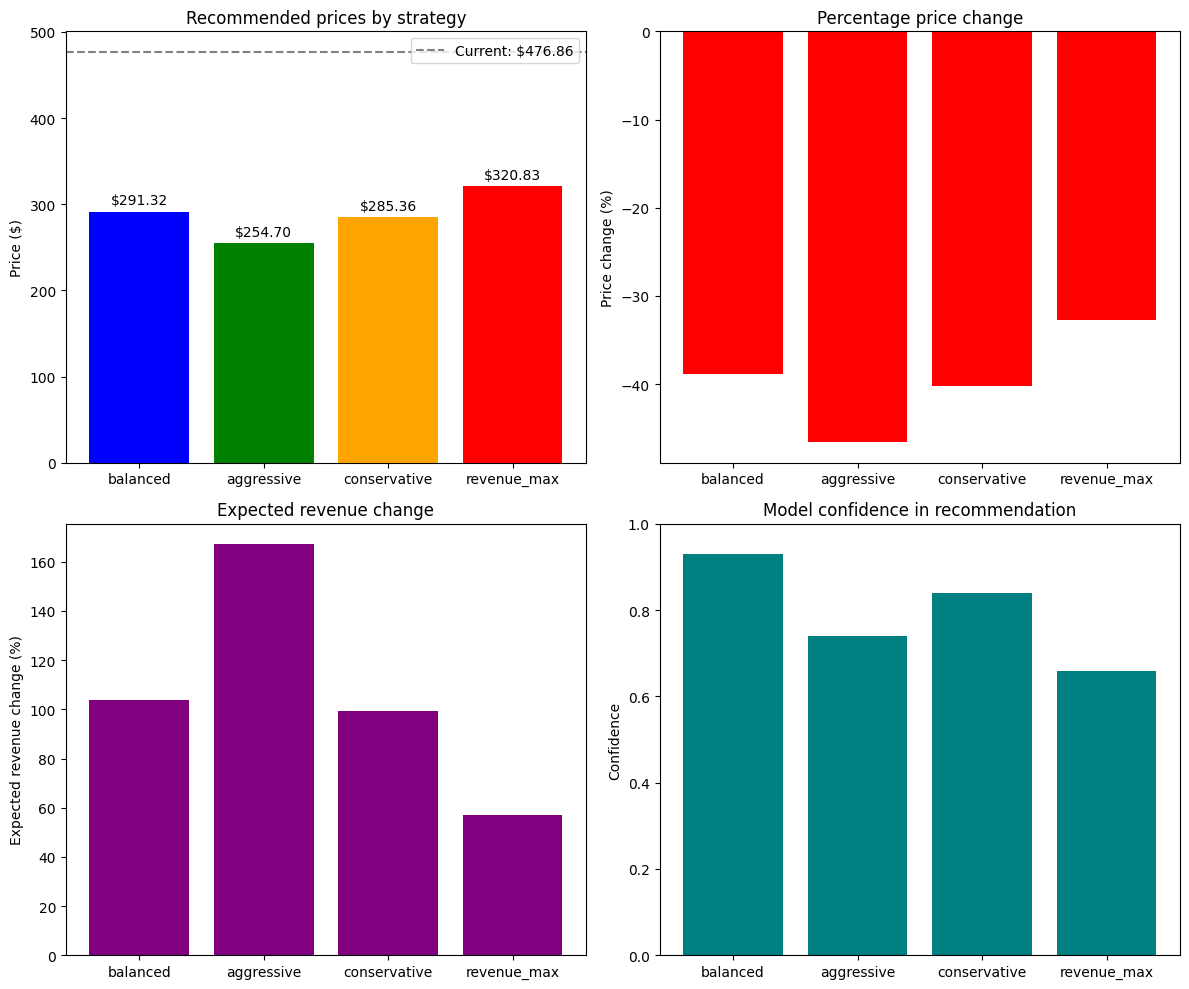

In [74]:
print("6. Testing /compare-strategies endpoint")

response = test_endpoint("POST", "/compare-strategies", optimize_payload)

if "error" not in response:
    comparison = response.get("strategies_comparison", {})
    print(f"\nComparison of {len(comparison)} strategies:")

    comparison_data = []
    for strategy, data in comparison.items():
        if "error" not in data:
            comparison_data.append({
                "Strategy": strategy,
                "Current price": response.get("current_price", 0),
                "Recommended price": data.get("recommended_price", 0),
                "Change (%)": data.get("price_change_pct", 0),
                "Expected revenue change (%)": data.get("expected_revenue_change_pct", 0),
                "Action": data.get("action", ""),
                "Category": data.get("recommended_category", ""),
                "Confidence": data.get("confidence", 0)
            })
        else:
            print(f"\n{strategy}: Error - {data.get('error')}")
    
    df_comparison = pd.DataFrame(comparison_data)
    display(df_comparison)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax = axes[0, 0]
    strategies = df_comparison["Strategy"]
    prices = df_comparison["Recommended price"]
    current_price = df_comparison["Current price"].iloc[0]
    
    bars = ax.bar(strategies, prices, color=['blue', 'green', 'orange', 'red'][:len(prices)])
    ax.axhline(y=current_price, color='gray', linestyle='--', label=f'Current: ${current_price:.2f}')
    ax.set_ylabel('Price ($)')
    ax.set_title('Recommended prices by strategy')
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'${height:.2f}', ha='center', va='bottom')

    ax = axes[0, 1]
    changes = df_comparison["Change (%)"]
    colors = ['red' if x < 0 else 'green' for x in changes]
    ax.bar(strategies, changes, color=colors)
    ax.set_ylabel('Price change (%)')
    ax.set_title('Percentage price change')
    ax.axhline(y=0, color='black', linewidth=0.5)

    ax = axes[1, 0]
    revenue_changes = df_comparison["Expected revenue change (%)"]
    ax.bar(strategies, revenue_changes, color='purple')
    ax.set_ylabel('Expected revenue change (%)')    
    ax.set_title('Expected revenue change')
    ax.axhline(y=0, color='black', linewidth=0.5)

    ax = axes[1, 1]
    confidences = df_comparison["Confidence"]
    ax.bar(strategies, confidences, color='teal')
    ax.set_ylabel('Confidence')
    ax.set_title('Model confidence in recommendation')
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

else:
    print(f"Error: {response.get('error')}")


In [75]:
%%bash
curl -X POST "http://localhost:8000/compare-strategies" \
  -H "Content-Type: application/json" \
  -d '{
    "listing_features": {
      "room_type": "Entire home/apt",
      "property_type": "Entire rental unit",
      "accommodates": 4.0,
      "bedrooms": 2.0,
      "beds": 2.0,
      "bathrooms": 1.0,
      "city": "Athens",
      "neighbourhood_cleansed": "ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ",
      "latitude": 37.97506,
      "longitude": 23.73068,
      "minimum_nights": 3.0,
      "maximum_nights": 365.0,
      "host_is_superhost": 1.0,
      "amenities_count": 45.0,
      "number_of_reviews": 33.0,
      "reviews_per_month": 0.22,
      "avg_rating": 4.5,
      "review_count": 33.0,
      "review_scores_rating": 4.84,
      "review_scores_accuracy": 4.91,
      "review_scores_cleanliness": 4.91,
      "review_scores_checkin": 4.88,
      "review_scores_communication": 4.88,
      "review_scores_location": 5.0,
      "review_scores_value": 4.76
    },
    "current_price": 476.86,
    "strategy": "balanced"
  }'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1718  100   781  100   937   5613   6734 --:--:-- --:--:-- --:--:-- 12359


{"current_price":476.86,"strategies_comparison":{"balanced":{"recommended_price":291.32,"price_change_pct":-38.91,"expected_revenue_change_pct":103.64,"confidence":0.93,"action":"decrease","competitiveness_score":0.965},"aggressive":{"recommended_price":254.33,"price_change_pct":-46.67,"expected_revenue_change_pct":166.67,"confidence":0.74,"action":"decrease","competitiveness_score":0.965},"conservative":{"recommended_price":280.51,"price_change_pct":-41.17,"expected_revenue_change_pct":96.08,"confidence":0.84,"action":"decrease","competitiveness_score":0.965},"revenue_max":{"recommended_price":334.35,"price_change_pct":-29.88,"expected_revenue_change_pct":63.6,"confidence":0.66,"action":"decrease","competitiveness_score":0.974}},"timestamp":"2026-01-16T22:00:47.387416"}

### Testowanie endpointu `/full-analysis`

Ten fragment notebooka testuje **kompleksowy endpoint `/full-analysis`**, który łączy w jednym wywołaniu:
- predykcję ceny (regresja),
- analizę aktualnej ceny (klasyfikacja),
- rekomendację optymalnej ceny (optymalizacja).

#### Zakres działania endpointu

Endpoint `/full-analysis` wykonuje **pełny pipeline decyzyjny** dla oferty noclegowej:

1. **Regression prediction**
   - Szacuje bazową cenę oferty na podstawie cech (`listing_features`)
   - Zwraca przewidywaną cenę w USD

2. **Price analysis**
   - Klasyfikuje aktualną cenę jako:
     - `low`
     - `normal`
     - `high`
   - Określa, czy cena jest konkurencyjna
   - Zwraca:
     - prawdopodobieństwa klas
     - rekomendacje biznesowe

3. **Optimization**
   - (Opcjonalnie) wyznacza rekomendowaną cenę
   - Uwzględnia strategię (`balanced`, `aggressive`, `conservative`)
   - Oblicza:
     - procentową zmianę ceny
     - oczekiwaną zmianę przychodu
     - poziom pewności decyzji


#### Wizualizacje

Notebook generuje **cztery wykresy**:

##### 1. Porównanie cen
- Aktualna cena
- Cena regresyjna (optymalna)
- Cena rekomendowana

##### 2. Rozkład prawdopodobieństw
- Wykres kołowy kategorii cen (`low / normal / high`)

##### 3. Rekomendacje
- Lista zaleceń biznesowych
- Prezentowana w formie poziomego wykresu

##### 4. Metryki optymalizacji
- Zmiana ceny (%)
- Oczekiwana zmiana przychodu (%)
- Pewność decyzji (%)


#### Test endpointu z użyciem `curl`

Druga część testu pokazuje wywołanie `/full-analysis` bezpośrednio z terminala:

- Pozwala zweryfikować API niezależnie od notebooka
- Przydatne w testach integracyjnych i CI/CD
- Dane wejściowe są identyczne jak w notebooku


7. Testing /full-analysis endpoint
Full analysis successful

1. Regression prediction:
   Predicted price: $291.32

2. Price analysis:
   Category: normal
   Competitive: Yes

3. Optimization:
   Recommended price: $291.32
   Change: -38.9%
   Action: decrease

Analysis timestamp: 2026-01-16T22:00:47.467882


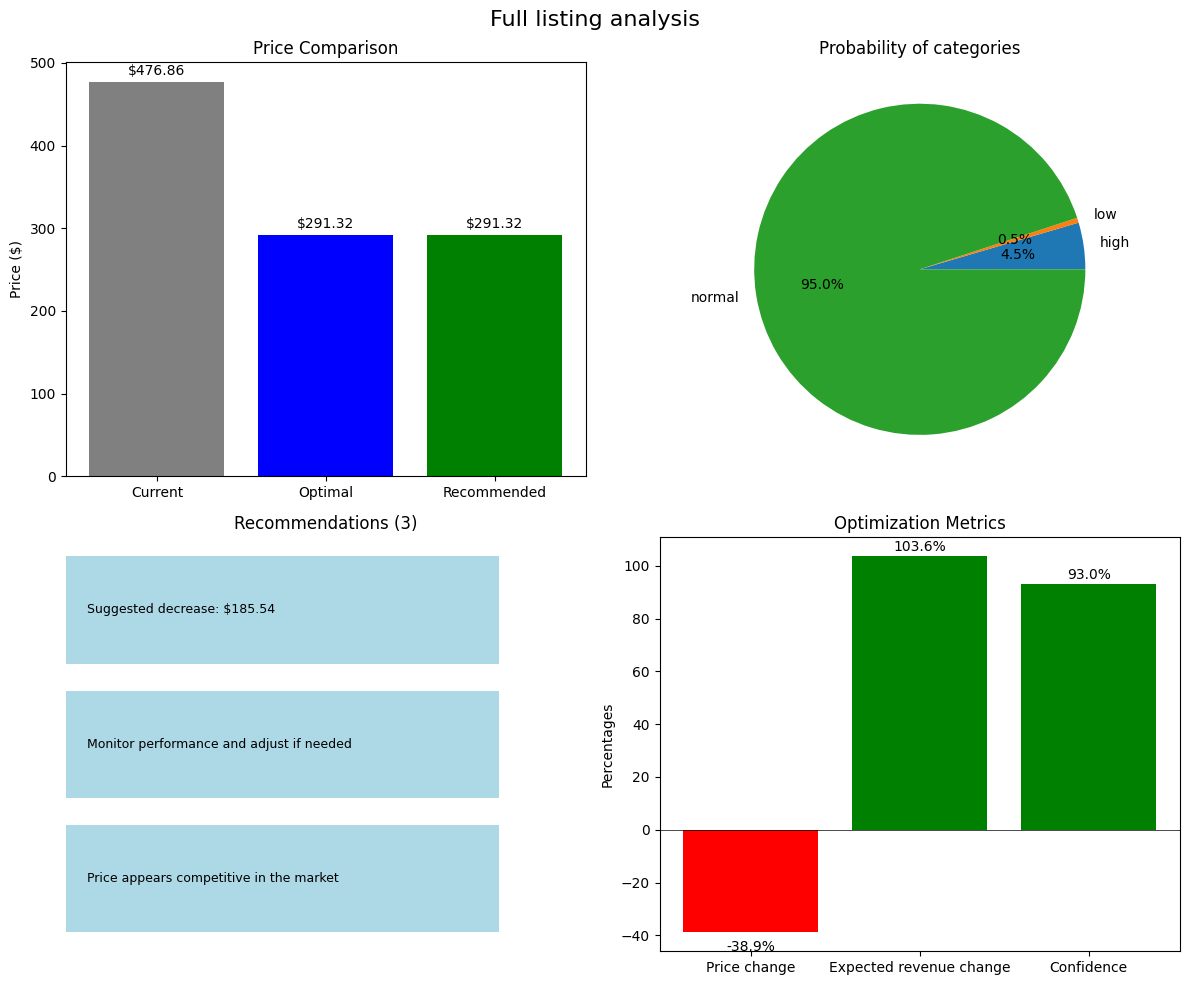

In [76]:
print("7. Testing /full-analysis endpoint")

full_analysis_payload = analyze_example

response = test_endpoint("POST", "/full-analysis", full_analysis_payload)

if "error" not in response:
    print("Full analysis successful")
    
    regression = response.get("regression_prediction", {})
    analysis = response.get("price_analysis", {})
    optimization = response.get("optimization", {})
    timestamp = response.get("timestamp", "")
    
    print(f"\n1. Regression prediction:")
    print(f"   Predicted price: ${regression.get('base_price_usd', 0):.2f}")

    print(f"\n2. Price analysis:")
    print(f"   Category: {analysis.get('predicted_category')}")
    print(f"   Competitive: {'Yes' if analysis.get('is_competitive') else 'No'}")
    
    if optimization:
        print(f"\n3. Optimization:")
        print(f"   Recommended price: ${optimization.get('recommended_price', 0):.2f}")
        print(f"   Change: {optimization.get('price_change_pct', 0):.1f}%")
        print(f"   Action: {optimization.get('action')}")
    else:
        print("\n3. Optimization: Unavailable (classifier not loaded)")
    
    print(f"\nAnalysis timestamp: {timestamp}")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    ax = axes[0, 0]
    prices = [
        analysis.get("current_price", 0),
        regression.get("base_price_usd", 0),
        optimization.get("recommended_price", 0) if optimization else 0
    ]
    labels = ["Current", "Optimal", "Recommended"]
    
    bars = ax.bar(labels[:len(prices)], prices, color=['gray', 'blue', 'green'])
    ax.set_ylabel('Price ($)')
    ax.set_title('Price Comparison')
    
    for bar, price in zip(bars, prices):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'${price:.2f}', ha='center', va='bottom')
    
    ax = axes[0, 1]
    if analysis.get("probabilities"):
        probs = analysis["probabilities"]
        categories = list(probs.keys())
        probabilities = list(probs.values())
        ax.pie(probabilities, labels=categories, autopct='%1.1f%%')
        ax.set_title('Probability of categories')
    
    ax = axes[1, 0]
    if analysis.get("recommendations"):
        recommendations = analysis["recommendations"]
        y_pos = range(len(recommendations))
        ax.barh(y_pos, [1] * len(recommendations), color='lightblue')
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"Rec. {i+1}" for i in y_pos])
        ax.set_xlim(0, 1.2)
        ax.set_title(f'Recommendations ({len(recommendations)})')
        ax.axis('off') 
        
        for i, rec in enumerate(recommendations):
            ax.text(0.05, i, rec, va='center', fontsize=9)
    
    ax = axes[1, 1]
    if optimization:
        metrics = {
            'Price change': optimization.get('price_change_pct', 0),
            'Expected revenue change': optimization.get('expected_revenue_change_pct', 0),
            'Confidence': optimization.get('confidence', 0) * 100
        }
        
        colors = ['red' if x < 0 else 'green' for x in 
                 [metrics['Price change'], metrics['Expected revenue change'], metrics['Confidence']]]

        bars = ax.bar(list(metrics.keys()), list(metrics.values()), color=colors)
        ax.set_ylabel('Percentages')
        ax.set_title('Optimization Metrics')
        ax.axhline(y=0, color='black', linewidth=0.5)
        
        for bar, value in zip(bars, metrics.values()):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                    f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')

    plt.suptitle('Full listing analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Error: {response.get('error')}")

In [77]:
%%bash
curl -X POST "http://localhost:8000/full-analysis" \
  -H "Content-Type: application/json" \
  -d '{
    "listing_features": {
      "room_type": "Entire home/apt",
      "property_type": "Entire rental unit",
      "accommodates": 4.0,
      "bedrooms": 2.0,
      "beds": 2.0,
      "bathrooms": 1.0,
      "city": "Athens",
      "neighbourhood_cleansed": "ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ",
      "latitude": 37.97506,
      "longitude": 23.73068,
      "minimum_nights": 3.0,
      "maximum_nights": 365.0,
      "host_is_superhost": 1.0,
      "amenities_count": 45.0,
      "number_of_reviews": 33.0,
      "reviews_per_month": 0.22,
      "avg_rating": 4.5,
      "review_count": 33.0,
      "review_scores_rating": 4.84,
      "review_scores_accuracy": 4.91,
      "review_scores_cleanliness": 4.91,
      "review_scores_checkin": 4.88,
      "review_scores_communication": 4.88,
      "review_scores_location": 5.0,
      "review_scores_value": 4.76
    },
    "current_price": 476.86,
    "strategy": "balanced"
  }'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  1740  100   803  100   937  14353  16748 --:--:-- --:--:-- --:--:-- 31636


{"regression_prediction":{"base_price_usd":291.31725196881905,"message":"Predicted optimal price: $291.32"},"price_analysis":{"current_price":476.86,"predicted_category":"normal","probabilities":{"high":0.04545578232317132,"low":0.004861511529986026,"normal":0.9496827061468428},"is_competitive":true,"confidence":0.9496827061468428,"recommendations":["Price appears competitive in the market","Monitor performance and adjust if needed","Suggested decrease: $185.54"]},"optimization":{"current_price":476.86,"recommended_price":291.32,"price_change_pct":-38.91,"current_category":"normal","recommended_category":"normal","expected_revenue_change_pct":103.64,"action":"decrease","explanation":"Decrease price to $291.32 to be more competitive","confidence":0.93},"timestamp":"2026-01-16T22:00:47.722043"}